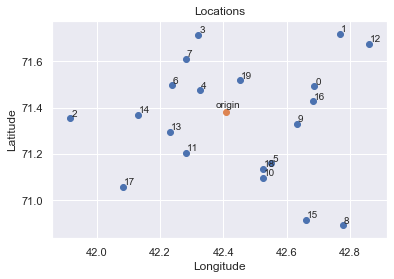

For comparison, to and from each would be a total distance of: 797.0856916742883


,Lat,Long,Demand,DistFromSource
0,42.687787,71.492002,8.589821,20.174731
1,42.767125,71.717759,6.633551,30.159233
2,41.917233,71.354872,83.698797,33.884852
3,42.320777,71.713197,58.633391,17.913379
4,42.325161,71.475087,16.024595,7.384165
5,42.551277,71.160434,84.118739,15.068534
6,42.236992,71.496484,96.358876,13.125958
7,42.281461,71.610607,39.474407,14.536767
8,42.777317,70.893610,46.309735,35.668704
9,42.632087,71.330367,12.908838,15.763478


In [544]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools

#set seaborn
sns.set()
n = 20
maxcap = 300

#Get our source and destinations
source = np.array([42.4072, 71.3824]) #LatLong of our DC in Massachusetts
destinations = np.random.random((n,2)) -.5 + source #For example, get 20 destinations near our source
demand = np.random.random((n,1)) * 100
df = pd.DataFrame({"Lat": destinations[:,0], "Long": destinations[:,1]})

#Make function to determine distance between two LatLongs
def latlongdiff(destination1, destination2):
    destination1 = destination1 * (math.pi/180) #LatLong should alreay be in degrees
    destination2 = destination2 * (math.pi/180)
    desDiff = 3959*(math.acos(math.sin(destination1[0]) * math.sin(destination2[0]) + 
                            math.cos(destination1[0]) * math.cos(destination2[0]) *
                            math.cos(destination1[1] - destination2[1])))
    return desDiff

#Make Panel Data of our Data
df = pd.DataFrame({"Lat": destinations[:,0], "Long": destinations[:,1]})
df["Demand"] = demand
df["DistFromSource"] = [latlongdiff(x, source) for x in destinations]

#Make a plot of starting data
plt.scatter(destinations[:,0], destinations[:,1])
plt.scatter(source[0], source[1])
for i in df.index:
    plt.text(df.iloc[i,0]+.003, df.iloc[i,1]+0.008, i, fontsize=10)
plt.text(source[0]-.03,source[1]+0.018, "origin", fontsize=10)
plt.xlabel('Longitude')
plt.ylabel("Latitude")
plt.title('Locations')
plt.show()

print("For comparison, to and from each would be a total distance of:", np.sum([latlongdiff(i, source) for i in destinations])*2)####
df


In [545]:
# Get all possible location combos
combos = list(itertools.combinations(list(range(n)),2))
desti = []
destj = []
savings = []

#Gather each combo's savings if a connection is made
for i, j in combos:
    savings.append(df.iloc[i,3] + df.iloc[j,3] - latlongdiff(df.iloc[i,0:2], df.iloc[j,0:2]))
    desti.append(i)
    destj.append(j)
    
#Combine our data and sort Saving combos in descending order    
sij = pd.DataFrame({'Dest_i' : desti, 'Dest_j': destj, 'Savings':savings}).sort_values('Savings', ascending= False).reset_index(drop=True)

#Create DataFrame to fill in data and record nodes that will be locked
paths = pd.DataFrame({"Route": [], "End_i": [], "End_j": [], "CapReached": [], "Savings": []})
lockedNodes = []

for index, i in enumerate(sij.values):
    ei = paths["End_i"].values
    ej = paths["End_j"].values
    #print("Step: ", str(index), "\n") ##For troubleshooting if needed
    #print(paths) ##Fore troubleshooting if needed
    #print(lockedNodes)
    
    #If a locked node is referenced, don't consider that combo
    if i[0] in lockedNodes and i[1] in lockedNodes:
        continue
    #if the Max Capacity between two potential connections is over the limit, don't consider that combo
    if df.loc[i[0],"Demand"] + df.loc[i[1],"Demand"] > maxcap:
        continue
    #If a combo is not yet references, 
    if ((i[0] not in ei and i[0] not in ej) and (i[1] not in ei and i[1] not in ej)) and (i[0] not in lockedNodes and i[1] not in lockedNodes): #Make new routes
        paths = paths.append({"Route": str(i[0])+"-"+str(i[1]), "End_i": i[0], "End_j": i[1], 
                              "CapReached": df.loc[i[0],"Demand"] + df.loc[i[1],"Demand"], 
                              "Savings": i[2]}, ignore_index= True)
        continue
    ######## Combining Paths when fluxing out, be sure to reset index after dropping later row
    if ((i[0] in ei or i[0] in ej) and (i[1] in ei or i[1] in ej)): #Add in comboing routes
        #continue #Uncomment this out if you want to not consider combining shorter routes
        if i[0] in ei and i[1] in ej:
            if paths.loc[paths["End_i"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_j"]==i[1],"CapReached"].values[0] > maxcap:
                continue
            elif paths[paths["End_i"]==i[0]].index == paths[paths["End_j"]==i[1]].index:
                continue
            else:
                lockedNodes.append(i[0])
                lockedNodes.append(i[1])
                paths.loc[paths["End_i"]==i[0], "Route"] = paths.loc[paths["End_j"]==i[1], "Route"].values[0] + "-" + paths.loc[paths["End_i"]==i[0], "Route"].values[0]
                paths.loc[paths["End_i"]==i[0], "CapReached"] = paths.loc[paths["End_i"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_j"]==i[1],"CapReached"].values[0]
                paths.loc[paths["End_i"]==i[0], "Savings"] = paths.loc[paths["End_i"]==i[0],"Savings"].values[0] + paths.loc[paths["End_j"]==i[1],"Savings"].values[0] + i[2]
                _del = paths[paths["End_j"]==i[1]].index
                paths.loc[paths["End_i"]==i[0], "End_i"] = paths.loc[paths["End_j"]==i[1], "End_i"].values[0]
                paths = paths.drop(_del).reset_index(drop=True)
        #####
        if i[0] in ei and i[1] in ei: #special because needs reverse
            if paths.loc[paths["End_i"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_i"]==i[1],"CapReached"].values[0] > maxcap:
                continue
            elif paths[paths["End_i"]==i[0]].index == paths[paths["End_i"]==i[1]].index:
                continue
            else:
                lockedNodes.append(i[0])
                lockedNodes.append(i[1])
                paths.loc[paths["End_i"]==i[0], "Route"] = "-".join(reversed(paths.loc[paths["End_i"]==i[1], "Route"].values[0].split("-"))) + "-" + paths.loc[paths["End_i"]==i[0], "Route"].values[0]
                paths.loc[paths["End_i"]==i[0], "CapReached"] = paths.loc[paths["End_i"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_i"]==i[1],"CapReached"].values[0]
                paths.loc[paths["End_i"]==i[0], "Savings"] = paths.loc[paths["End_i"]==i[0],"Savings"].values[0] + paths.loc[paths["End_i"]==i[1],"Savings"].values[0] + i[2]
                _del = paths[paths["End_i"]==i[1]].index
                paths.loc[paths["End_i"]==i[0], "End_i"] = paths.loc[paths["End_i"]==i[1], "End_j"].values[0]
                paths = paths.drop(_del).reset_index(drop=True)
        #####
        if i[0] in ej and i[1] in ei:
            if paths.loc[paths["End_j"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_i"]==i[1],"CapReached"].values[0] > maxcap:
                continue
            elif paths[paths["End_j"]==i[0]].index == paths[paths["End_i"]==i[1]].index:
                continue
            else:
                lockedNodes.append(i[0])
                lockedNodes.append(i[1])
                paths.loc[paths["End_j"]==i[0], "Route"] = paths.loc[paths["End_j"]==i[0], "Route"].values[0] + "-" + paths.loc[paths["End_i"]==i[1], "Route"].values[0]
                paths.loc[paths["End_j"]==i[0], "CapReached"] = paths.loc[paths["End_j"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_i"]==i[1],"CapReached"].values[0]
                paths.loc[paths["End_j"]==i[0], "Savings"] = paths.loc[paths["End_j"]==i[0],"Savings"].values[0] + paths.loc[paths["End_i"]==i[1],"Savings"].values[0] + i[2]
                _del = paths[paths["End_i"]==i[1]].index
                paths.loc[paths["End_j"]==i[0], "End_j"] = paths.loc[paths["End_i"]==i[1], "End_j"].values[0]
                paths = paths.drop(_del).reset_index(drop=True)
        #####
        if i[0] in ej and i[1] in ej: #special because needs reverse
            if paths.loc[paths["End_j"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_j"]==i[1],"CapReached"].values[0] > maxcap:
                continue
            elif paths[paths["End_j"]==i[0]].index == paths[paths["End_j"]==i[1]].index:
                continue
            else:
                lockedNodes.append(i[0])
                lockedNodes.append(i[1])
                paths.loc[paths["End_j"]==i[0], "Route"] = paths.loc[paths["End_j"]==i[0], "Route"].values[0] + "-" + "-".join(reversed(paths.loc[paths["End_j"]==i[1], "Route"].values[0].split("-")))
                paths.loc[paths["End_j"]==i[0], "CapReached"] = paths.loc[paths["End_j"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_j"]==i[1],"CapReached"].values[0]
                paths.loc[paths["End_j"]==i[0], "Savings"] = paths.loc[paths["End_j"]==i[0],"Savings"].values[0] + paths.loc[paths["End_j"]==i[1],"Savings"].values[0] + i[2]
                _del = paths[paths["End_j"]==i[1]].index
                paths.loc[paths["End_j"]==i[0], "End_j"] = paths.loc[paths["End_j"]==i[1], "End_i"].values[0]
                paths = paths.drop(_del).reset_index(drop=True)
        continue
        
    ########### Below updates routes if a combo can be appended to an end of the route, sep w/ #####
    if (len(ei[ei==i[0]])==1 and i[0] not in ej) and (i[0] not in lockedNodes and i[1] not in lockedNodes):
        if paths.loc[paths["End_i"]==i[0],"CapReached"].values[0] + df.loc[i[1],"Demand"] > maxcap:
            continue
        else:
            lockedNodes.append(i[0])
            paths.loc[paths["End_i"]==i[0], "Route"] = str(i[1])+"-"+ paths.loc[paths["End_i"]==i[0],"Route"]
            paths.loc[paths["End_i"]==i[0], "CapReached"] = paths.loc[paths["End_i"]==i[0],"CapReached"].values[0] + df.loc[i[1],"Demand"]
            paths.loc[paths["End_i"]==i[0], "Savings"] = paths.loc[paths["End_i"]==i[0],"Savings"].values[0] + i[2]
            paths.loc[paths["End_i"]==i[0], "End_i"] = i[1]
    #####   
    if (len(ej[ej==i[0]])==1 and i[0] not in ei) and (i[0] not in lockedNodes and i[1] not in lockedNodes):
        if paths.loc[paths["End_j"]==i[0],"CapReached"].values[0] + df.loc[i[1],"Demand"] > maxcap:
            continue
        else:
            lockedNodes.append(i[0])
            paths.loc[paths["End_j"]==i[0], "Route"] = paths.loc[paths["End_j"]==i[0],"Route"] + "-" + str(i[1])
            paths.loc[paths["End_j"]==i[0], "CapReached"] = paths.loc[paths["End_j"]==i[0],"CapReached"].values[0] + df.loc[i[1],"Demand"]
            paths.loc[paths["End_j"]==i[0], "Savings"] = paths.loc[paths["End_j"]==i[0],"Savings"].values[0] + i[2]
            paths.loc[paths["End_j"]==i[0], "End_j"] = i[1]
    #####
    if (len(ei[ei==i[1]])==1 and i[1] not in ej) and (i[1] not in lockedNodes and i[0] not in lockedNodes):
        if paths.loc[paths["End_i"]==i[1],"CapReached"].values[0] + df.loc[i[0],"Demand"] > maxcap:
            continue
        else:
            lockedNodes.append(i[1])
            paths.loc[paths["End_i"]==i[1], "Route"] = str(i[0])+"-"+ paths.loc[paths["End_i"]==i[1],"Route"]
            paths.loc[paths["End_i"]==i[1], "CapReached"] = paths.loc[paths["End_i"]==i[1],"CapReached"].values[0] + df.loc[i[0],"Demand"]
            paths.loc[paths["End_i"]==i[1], "Savings"] = paths.loc[paths["End_i"]==i[1],"Savings"].values[0] + i[2]
            paths.loc[paths["End_i"]==i[1], "End_i"] = i[0]
    #####
    if (len(ej[ej==i[1]])==1 and i[1] not in ei) and (i[1] not in lockedNodes and i[0] not in lockedNodes):
        if paths.loc[paths["End_j"]==i[1],"CapReached"].values[0] + df.loc[i[0],"Demand"] > maxcap:
            continue
        else:
            lockedNodes.append(i[1])
            paths.loc[paths["End_j"]==i[1], "Route"] = paths.loc[paths["End_j"]==i[1],"Route"]+"-"+str(i[0])
            paths.loc[paths["End_j"]==i[1], "CapReached"] = paths.loc[paths["End_j"]==i[1],"CapReached"].values[0] + df.loc[i[0],"Demand"]
            paths.loc[paths["End_j"]==i[1], "Savings"] = paths.loc[paths["End_j"]==i[1],"Savings"].values[0] + i[2]
            paths.loc[paths["End_j"]==i[1], "End_j"] = i[0]

#Any routes that couldn't fit in another route (normally closer locations) need their own route
leftovers = set(df.index) - set(lockedNodes + list(paths["End_i"].values) + list(paths["End_j"]))
if len(leftovers) > 0:
    for lo in leftovers:
        paths = paths.append({"Route": str(lo) + ".0", "End_i": lo, "End_j": lo, #Need to change if char index
                              "CapReached": df.loc[lo,"Demand"], 
                              "Savings": 0}, ignore_index= True)
paths

,Route,End_i,End_j,CapReached,Savings
0,19.0-1.0-12.0-0.0-16.0-9.0-11.0,19.0,11.0,261.113954,179.619137
1,5.0-8.0-15.0-10.0-18.0,5.0,18.0,239.751356,149.733808
2,14.0-2.0-17.0-13.0,14.0,13.0,241.418215,105.983565
3,3.0-7.0-6.0-4.0,3.0,4.0,210.491269,61.932684


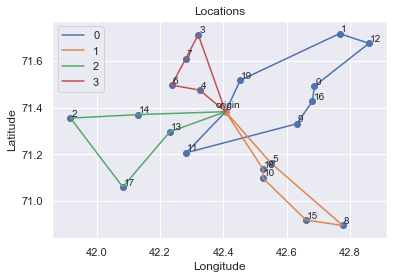

Maximum Capacity: 300 , # of Locations:  20
Total Savings in Distance: 497.2691933522327  saved out of an otherwise 797.0856916742883
Vehicle Utilization:  79.39789951601809 %


,Route,End_i,End_j,CapReached,Savings
0,19.0-1.0-12.0-0.0-16.0-9.0-11.0,19.0,11.0,261.113954,179.619137
1,5.0-8.0-15.0-10.0-18.0,5.0,18.0,239.751356,149.733808
2,14.0-2.0-17.0-13.0,14.0,13.0,241.418215,105.983565
3,3.0-7.0-6.0-4.0,3.0,4.0,210.491269,61.932684


In [546]:
#leftover = list(df.index).drop(lockedNodes)
for index, route in enumerate(paths["Route"].str.replace("\.0", "")):
    x = [source[0]]
    y = [source[1]]
    for dest in route.split("-"):
        x.append(df.loc[int(dest),"Lat"])
        y.append(df.loc[int(dest),"Long"])
    x.append(source[0])
    y.append(source[1])
    plt.plot(x, y)   
plt.scatter(destinations[:,0], destinations[:,1])
plt.scatter(source[0], source[1])
for i in df.index:
    plt.text(df.iloc[i,0]+.003, df.iloc[i,1]+0.008, i, fontsize=10)
plt.text(source[0]-.03,source[1]+0.018, "origin", fontsize=10)
plt.xlabel('Longitude')
plt.ylabel("Latitude")
plt.title('Locations')
plt.legend(paths["Route"].index)
plt.show()

print("Maximum Capacity:", maxcap, ", # of Locations: ", len(df))
print("Total Savings in Distance:", paths["Savings"].sum(), " saved out of an otherwise", np.sum([latlongdiff(i, source) for i in destinations])*2)####
print("Vehicle Utilization: ", (paths["CapReached"].sum()/(len(paths)*maxcap))*100,"%")

paths
        

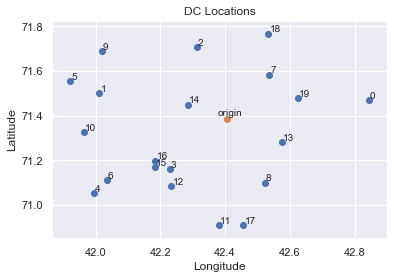

In [237]:
plt.scatter(destinations[:,0], destinations[:,1])
plt.scatter(source[0], source[1])
for i in df.index:
    plt.text(df.iloc[i,0]+.003, df.iloc[i,1]+0.008, i, fontsize=10)
plt.text(source[0]-.03,source[1]+0.018, "origin", fontsize=10)
plt.xlabel('Longitude')
plt.ylabel("Latitude")
plt.title('DC Locations')
plt.show()

In [488]:
df

,Lat,Long,Demand,DistFromSource
0,42.815174,71.662432,24.889689,31.582682
1,42.670643,71.165560,77.987777,21.289352
2,42.484081,71.846385,54.021204,24.246904
3,42.239722,71.000039,95.876025,22.704430
4,42.318108,71.090261,46.768335,16.135861
5,42.024961,71.190897,95.342594,28.171316
6,41.919346,71.090513,72.858130,36.875766
7,41.984109,70.979191,3.044526,35.786793
8,42.762675,71.252593,80.388200,25.434752
9,42.642034,71.856034,57.970820,29.069484


In [329]:
sij

,Dest_i,Dest_j,Savings
0,3,19,65.845602
1,3,10,56.233981
2,10,19,56.020964
3,4,11,55.214513
4,11,17,53.314340
5,1,17,52.498472
6,5,6,48.725599
7,1,11,48.104054
8,8,14,47.225455
9,0,4,45.974416


In [287]:
paths["Savings"].sum()


[5.0, 4.0, 6.0, 15.0, 17.0, 11.0, 12.0, 9.0, 0.0, 18.0, 1.0, 19.0]

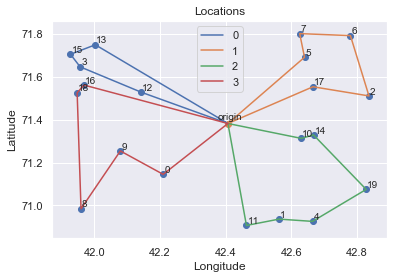

Maximum Capacity: 300 , # of Locations:  20
Total Savings in Distance: 733.8213686825259 saved out of an otherwise 1090.8091097951783
Vehicle Utilization:  81.62707024893743 %


,Route,End_i,End_j,CapReached,Savings
0,12.0-3.0-15.0-13.0,12.0,13.0,206.234896,171.715787
1,17.0-2.0-6.0-7.0-5.0,17.0,5.0,251.443368,178.611361
2,11.0-1.0-4.0-19.0-14.0-10.0,11.0,10.0,228.328921,204.311419
3,16.0-18.0-8.0-9.0-0.0,16.0,0.0,293.517658,179.182802


In [503]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools

#set seaborn
sns.set()
n = 20
maxcap = 300

#Get our source and destinations
source = np.array([42.4072, 71.3824]) #LatLong of our DC in Massachusetts
destinations = np.random.random((n,2)) -.5 + source #For example, get 20 destinations near our source
demand = np.random.random((n,1)) * 100
df = pd.DataFrame({"Lat": destinations[:,0], "Long": destinations[:,1]})

#Make function to determine distance between two LatLongs
def latlongdiff(destination1, destination2):
    destination1 = destination1 * (math.pi/180) #LatLong should alreay be in degrees
    destination2 = destination2 * (math.pi/180)
    desDiff = 3959*(math.acos(math.sin(destination1[0]) * math.sin(destination2[0]) + 
                            math.cos(destination1[0]) * math.cos(destination2[0]) *
                            math.cos(destination1[1] - destination2[1])))
    return desDiff

#Make Panel Data of our Data
df = pd.DataFrame({"Lat": destinations[:,0], "Long": destinations[:,1]})
df["Demand"] = demand
df["DistFromSource"] = [latlongdiff(x, source) for x in destinations]

# Get all possible location combos
combos = list(itertools.combinations(list(range(n)),2))
desti = []
destj = []
savings = []

#Gather each combo's savings if a connection is made
for i, j in combos:
    savings.append(df.iloc[i,3] + df.iloc[j,3] - latlongdiff(df.iloc[i,0:2], df.iloc[j,0:2]))
    desti.append(i)
    destj.append(j)
    
#Combine our data and sort Saving combos in descending order    
sij = pd.DataFrame({'Dest_i' : desti, 'Dest_j': destj, 'Savings':savings}).sort_values('Savings', ascending= False).reset_index(drop=True)

#Create DataFrame to fill in data and record nodes that will be locked
paths = pd.DataFrame({"Route": [], "End_i": [], "End_j": [], "CapReached": [], "Savings": []})
lockedNodes = []

for index, i in enumerate(sij.values):
    ei = paths["End_i"].values
    ej = paths["End_j"].values
    #print("Step: ", str(index), "\n") ##For troubleshooting if needed
    #print(paths) ##Fore troubleshooting if needed
    
    #If a locked node is referenced, don't consider that combo
    if i[0] in lockedNodes and i[1] in lockedNodes:
        continue
    #if the Max Capacity between two potential connections is over the limit, don't consider that combo
    if df.loc[i[0],"Demand"] + df.loc[i[1],"Demand"] > maxcap:
        continue
    #If a combo is not yet references, 
    if ((i[0] not in ei and i[0] not in ej) and (i[1] not in ei and i[1] not in ej)) and (i[0] not in lockedNodes and i[1] not in lockedNodes): #Make new routes
        paths = paths.append({"Route": str(i[0])+"-"+str(i[1]), "End_i": i[0], "End_j": i[1], 
                              "CapReached": df.loc[i[0],"Demand"] + df.loc[i[1],"Demand"], 
                              "Savings": i[2]}, ignore_index= True)
        continue
    ######## Combining Paths when fluxing out, be sure to reset index after dropping later row
    if ((i[0] in ei or i[0] in ej) and (i[1] in ei or i[1] in ej)): #Add in comboing routes
        #continue #Uncomment this out if you want to not consider combining shorter routes
        if i[0] in ei and i[1] in ej:
            if paths.loc[paths["End_i"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_j"]==i[1],"CapReached"].values[0] > maxcap:
                continue
            elif paths[paths["End_i"]==i[0]].index == paths[paths["End_j"]==i[1]].index:
                continue
            else:
                lockedNodes.append(i[0])
                lockedNodes.append(i[1])
                paths.loc[paths["End_i"]==i[0], "Route"] = paths.loc[paths["End_j"]==i[1], "Route"].values[0] + "-" + paths.loc[paths["End_i"]==i[0], "Route"].values[0]
                paths.loc[paths["End_i"]==i[0], "CapReached"] = paths.loc[paths["End_i"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_j"]==i[1],"CapReached"].values[0]
                paths.loc[paths["End_i"]==i[0], "Savings"] = paths.loc[paths["End_i"]==i[0],"Savings"].values[0] + paths.loc[paths["End_j"]==i[1],"Savings"].values[0] + i[2]
                _del = paths[paths["End_j"]==i[1]].index
                paths.loc[paths["End_i"]==i[0], "End_i"] = paths.loc[paths["End_j"]==i[1], "End_i"].values[0]
                paths = paths.drop(_del).reset_index(drop=True)
        #####
        if i[0] in ei and i[1] in ei: #special because needs reverse
            if paths.loc[paths["End_i"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_i"]==i[1],"CapReached"].values[0] > maxcap:
                continue
            elif paths[paths["End_i"]==i[0]].index == paths[paths["End_i"]==i[1]].index:
                continue
            else:
                lockedNodes.append(i[0])
                lockedNodes.append(i[1])
                paths.loc[paths["End_i"]==i[0], "Route"] = "-".join(reversed(paths.loc[paths["End_i"]==i[1], "Route"].values[0].split("-"))) + "-" + paths.loc[paths["End_i"]==i[0], "Route"].values[0]
                paths.loc[paths["End_i"]==i[0], "CapReached"] = paths.loc[paths["End_i"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_i"]==i[1],"CapReached"].values[0]
                paths.loc[paths["End_i"]==i[0], "Savings"] = paths.loc[paths["End_i"]==i[0],"Savings"].values[0] + paths.loc[paths["End_i"]==i[1],"Savings"].values[0] + i[2]
                _del = paths[paths["End_i"]==i[1]].index
                paths.loc[paths["End_i"]==i[0], "End_i"] = paths.loc[paths["End_i"]==i[1], "End_j"].values[0]
                paths = paths.drop(_del).reset_index(drop=True)
        #####
        if i[0] in ej and i[1] in ei:
            if paths.loc[paths["End_j"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_i"]==i[1],"CapReached"].values[0] > maxcap:
                continue
            elif paths[paths["End_j"]==i[0]].index == paths[paths["End_i"]==i[1]].index:
                continue
            else:
                lockedNodes.append(i[0])
                lockedNodes.append(i[1])
                paths.loc[paths["End_j"]==i[0], "Route"] = paths.loc[paths["End_j"]==i[0], "Route"].values[0] + "-" + paths.loc[paths["End_i"]==i[1], "Route"].values[0]
                paths.loc[paths["End_j"]==i[0], "CapReached"] = paths.loc[paths["End_j"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_i"]==i[1],"CapReached"].values[0]
                paths.loc[paths["End_j"]==i[0], "Savings"] = paths.loc[paths["End_j"]==i[0],"Savings"].values[0] + paths.loc[paths["End_i"]==i[1],"Savings"].values[0] + i[2]
                _del = paths[paths["End_i"]==i[1]].index
                paths.loc[paths["End_j"]==i[0], "End_j"] = paths.loc[paths["End_i"]==i[1], "End_j"].values[0]
                paths = paths.drop(_del).reset_index(drop=True)
        #####
        if i[0] in ej and i[1] in ej: #special because needs reverse
            if paths.loc[paths["End_j"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_j"]==i[1],"CapReached"].values[0] > maxcap:
                continue
            elif paths[paths["End_j"]==i[0]].index == paths[paths["End_j"]==i[1]].index:
                continue
            else:
                lockedNodes.append(i[0])
                lockedNodes.append(i[1])
                paths.loc[paths["End_j"]==i[0], "Route"] = paths.loc[paths["End_j"]==i[0], "Route"].values[0] + "-" + "-".join(reversed(paths.loc[paths["End_j"]==i[1], "Route"].values[0].split("-")))
                paths.loc[paths["End_j"]==i[0], "CapReached"] = paths.loc[paths["End_j"]==i[0],"CapReached"].values[0] + paths.loc[paths["End_j"]==i[1],"CapReached"].values[0]
                paths.loc[paths["End_j"]==i[0], "Savings"] = paths.loc[paths["End_j"]==i[0],"Savings"].values[0] + paths.loc[paths["End_j"]==i[1],"Savings"].values[0] + i[2]
                _del = paths[paths["End_j"]==i[1]].index
                paths.loc[paths["End_j"]==i[0], "End_j"] = paths.loc[paths["End_j"]==i[1], "End_i"].values[0]
                paths = paths.drop(_del).reset_index(drop=True)
        continue
        
    ########### Below updates routes if a combo can be appended to an end of the route, sep w/ #####
    if (len(ei[ei==i[0]])==1 and i[0] not in ej) and (i[0] not in lockedNodes and i[1] not in lockedNodes):
        if paths.loc[paths["End_i"]==i[0],"CapReached"].values[0] + df.loc[i[1],"Demand"] > maxcap:
            continue
        else:
            lockedNodes.append(i[0])
            paths.loc[paths["End_i"]==i[0], "Route"] = str(i[1])+"-"+ paths.loc[paths["End_i"]==i[0],"Route"]
            paths.loc[paths["End_i"]==i[0], "CapReached"] = paths.loc[paths["End_i"]==i[0],"CapReached"].values[0] + df.loc[i[1],"Demand"]
            paths.loc[paths["End_i"]==i[0], "Savings"] = paths.loc[paths["End_i"]==i[0],"Savings"].values[0] + i[2]
            paths.loc[paths["End_i"]==i[0], "End_i"] = i[1]
    #####   
    if (len(ej[ej==i[0]])==1 and i[0] not in ei) and (i[0] not in lockedNodes and i[1] not in lockedNodes):
        if paths.loc[paths["End_j"]==i[0],"CapReached"].values[0] + df.loc[i[1],"Demand"] > maxcap:
            continue
        else:
            lockedNodes.append(i[0])
            paths.loc[paths["End_j"]==i[0], "Route"] = paths.loc[paths["End_j"]==i[0],"Route"] + "-" + str(i[1])
            paths.loc[paths["End_j"]==i[0], "CapReached"] = paths.loc[paths["End_j"]==i[0],"CapReached"].values[0] + df.loc[i[1],"Demand"]
            paths.loc[paths["End_j"]==i[0], "Savings"] = paths.loc[paths["End_j"]==i[0],"Savings"].values[0] + i[2]
            paths.loc[paths["End_j"]==i[0], "End_j"] = i[1]
    #####
    if (len(ei[ei==i[1]])==1 and i[1] not in ej) and (i[1] not in lockedNodes and i[0] not in lockedNodes):
        if paths.loc[paths["End_i"]==i[1],"CapReached"].values[0] + df.loc[i[0],"Demand"] > maxcap:
            continue
        else:
            lockedNodes.append(i[1])
            paths.loc[paths["End_i"]==i[1], "Route"] = str(i[0])+"-"+ paths.loc[paths["End_i"]==i[1],"Route"]
            paths.loc[paths["End_i"]==i[1], "CapReached"] = paths.loc[paths["End_i"]==i[1],"CapReached"].values[0] + df.loc[i[0],"Demand"]
            paths.loc[paths["End_i"]==i[1], "Savings"] = paths.loc[paths["End_i"]==i[1],"Savings"].values[0] + i[2]
            paths.loc[paths["End_i"]==i[1], "End_i"] = i[0]
    #####
    if (len(ej[ej==i[1]])==1 and i[1] not in ei) and (i[1] not in lockedNodes and i[0] not in lockedNodes):
        if paths.loc[paths["End_j"]==i[1],"CapReached"].values[0] + df.loc[i[0],"Demand"] > maxcap:
            continue
        else:
            lockedNodes.append(i[1])
            paths.loc[paths["End_j"]==i[1], "Route"] = paths.loc[paths["End_j"]==i[1],"Route"]+"-"+str(i[0])
            paths.loc[paths["End_j"]==i[1], "CapReached"] = paths.loc[paths["End_j"]==i[1],"CapReached"].values[0] + df.loc[i[0],"Demand"]
            paths.loc[paths["End_j"]==i[1], "Savings"] = paths.loc[paths["End_j"]==i[1],"Savings"].values[0] + i[2]
            paths.loc[paths["End_j"]==i[1], "End_j"] = i[0]

#Any routes that couldn't fit in another route (normally closer locations) need their own route
leftovers = set(df.index) - set(lockedNodes + list(paths["End_i"].values) + list(paths["End_j"]))
if len(leftovers) > 0:
    for lo in leftovers:
        paths = paths.append({"Route": str(lo) +".0", "End_i": lo, "End_j": lo, #Change Route if char index
                              "CapReached": df.loc[lo,"Demand"], 
                              "Savings": 0}, ignore_index= True)

for index, route in enumerate(paths["Route"].str.replace("\.0", "")):
    x = [source[0]]
    y = [source[1]]
    for dest in route.split("-"):
        x.append(df.loc[int(dest),"Lat"])
        y.append(df.loc[int(dest),"Long"])
    x.append(source[0])
    y.append(source[1])
    plt.plot(x, y)   
plt.scatter(destinations[:,0], destinations[:,1])
plt.scatter(source[0], source[1])
for i in df.index:
    plt.text(df.iloc[i,0]+.003, df.iloc[i,1]+0.008, i, fontsize=10)
plt.text(source[0]-.03,source[1]+0.018, "origin", fontsize=10)
plt.xlabel('Longitude')
plt.ylabel("Latitude")
plt.title('Locations')
plt.legend(paths["Route"].index)
plt.show()

print("Maximum Capacity:", maxcap, ", # of Locations: ", len(df))
print("Total Savings in Distance:", paths["Savings"].sum(), "saved out of an otherwise", np.sum([latlongdiff(i, source) for i in destinations])*2)####
print("Vehicle Utilization: ", (paths["CapReached"].sum()/(len(paths)*maxcap))*100,"%")

paths

In [447]:
#"-".join(reversed(paths.loc[paths["End_i"]==7, "Route"].values[0].split("-")))
#paths.loc[paths["End_i"]==7, "Route"].values[0]
leftovers = set(df.index) - set(lockedNodes + list(paths["End_i"].values) + list(paths["End_j"]))
compare = lockedNodes + list(paths["End_i"].values) + list(paths["End_j"])

#len(set(leftovers) - set(compare))
df.index


RangeIndex(start=0, stop=20, step=1)